In [1]:
from numpy.random import choice, normal, uniform, binomial
from numpy import sum, mean, zeros, array, NaN, sqrt, floor
import pandas as pd
from math import comb
from numpy.random import seed
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from tqdm import tqdm
import itertools
import warnings

from functools import partial
from joblib import Parallel, delayed

In [2]:
pd.options.mode.chained_assignment = None
seed(1234)

# Bias under different samplig sizes

We are going to replicate the `Synthetic Simulation.ipynb` many times to see whether bias disappears increasing the sample size or the number of simultaneous recommendations. 

Values to combine and try

In [3]:
items_n_values = [5, 10, 15]
k_prop_values = [0.25, 0.5, 0.75] 


Default parameters configuration

In [4]:
n_jobs = 2

patients_n = 50000
sessions_n = 2
delta = 0.1
exploration_prob = 0.5

prob_enthusiast = 0.4
enthusiast_effect = 10
base_consumption = 0.2
inc_enth_cons = 0.4

In [5]:
def simulate(items_n, k):
    ids = []
    sessions = []
    patient_types = []
    items = []
    recommendations = []
    consumptions = []
    originals = []
    explorations = []

    items_ids = list(range(items_n))

    k_i = 1
    k_e = k - 1

    for id in range(patients_n):
        patient_type = choice([0, 1], size=1, p=[1-prob_enthusiast, prob_enthusiast])[0]
        for session in range(sessions_n):
            exploration = binomial(1, exploration_prob, size=1)[0]
            original = None
            if patient_type == 1:
                original = items_ids[:k_i] + items_ids[-k_e:]
            else:
                original = items_ids[:k_e] + items_ids[-k_i:]
            if exploration == 1:
                recommended = choice(items_ids, size=k, replace=False)
            else:
                recommended = original

            recommended = [int(treat in recommended) for treat in items_ids]     
            original = [int(treat in original) for treat in items_ids]     

            consumption = []
            for treat in range(items_n):
                score_assign = base_consumption + inc_enth_cons*patient_type
                item_cons = int(uniform(size=1)[0] <= score_assign)
                item_cons *= recommended[treat]
                consumption.append(item_cons)

            ids += [id]*items_n
            sessions += [session]*items_n
            patient_types += [patient_type]*items_n
            items += items_ids
            recommendations += recommended
            consumptions += consumption
            explorations += [exploration]*items_n
            originals += original

    df = pd.DataFrame({
        'user_id': ids,
        'session': sessions, 
        'patient_type': patient_types,
        'item': items, 
        'original': originals,
        'recommended': recommendations,
        'consumed': consumptions,
        'exploration': explorations
    })

    outcomes = df.groupby('user_id').apply(lambda x: 
        (sum(x['item']*x['consumed'])/items_n + 
        mean(x['patient_type'])*enthusiast_effect + 
        normal(size=1, scale=delta))[0]
    ).reset_index()
    outcomes.rename(columns={0:'outcome'}, inplace = True)
    df = df.merge(outcomes, on='user_id')
    recs = df.pivot(index=['user_id', 'session', 'exploration'], columns='item', values='recommended').reset_index().merge(outcomes, on='user_id')
    originals = df.pivot(index=['user_id', 'session', 'exploration'], columns='item', values='original').reset_index().merge(outcomes, on='user_id')
    return(df, recs, originals)



In [6]:
def calculate_expected(recs, items_n):
    expected_diff_items = zeros((items_n, items_n))
    expected_compliers = base_consumption*(1-prob_enthusiast) + (base_consumption + inc_enth_cons)*prob_enthusiast
    for item_1 in range(items_n):
        for item_2 in range(items_n):
            expected_diff_items[item_1, item_2] = (item_1 - item_2)*expected_compliers/items_n

    return(expected_diff_items)

In [7]:
def calculate_direct(recs, items_n):
    diff_items_direct = zeros((items_n, items_n))

    for item_1 in range(items_n):
        for item_2 in range(items_n):
            try: 
                inds_1_0 = recs.loc[:, item_1] == 1
                inds_2_0 = recs.loc[:, item_2] == 1
                res_1 = recs[inds_1_0].loc[:, 'outcome'].mean() - recs[inds_2_0].loc[:, 'outcome'].mean()
            except:
                res_1 = NaN
            diff_items_direct[item_1, item_2] = res_1

    return(diff_items_direct)

In [8]:
def calculate_direct_incremental(recs, items_n):
    diff_items_direct_inc = zeros((items_n, items_n))

    for treat_1 in range(items_n):
        for treat_2 in range(items_n):
            try: 
                inds_1_0 = recs.loc[:, treat_1] == 1
                inds_2_0 = recs.loc[:, treat_2] == 1
                impact_1 = recs[inds_1_0].loc[:, 'outcome'].mean() - recs[~inds_1_0].loc[:, 'outcome'].mean()
                impact_2 = recs[inds_2_0].loc[:, 'outcome'].mean() - recs[~inds_2_0].loc[:, 'outcome'].mean()
                res_1 = impact_1 - impact_2
            except:
                res_1 = NaN
            diff_items_direct_inc[treat_1, treat_2] = res_1

    return(diff_items_direct_inc)

In [9]:
def calculate_ipw(recs, originals, items_n):
    diff_treats_ipw = zeros((items_n, items_n))
    items_ids = list(range(items_n))

    N = items_n

    for treat_1, treat_2 in list(itertools.product(items_ids, items_ids)):

        propensity_scores_1 = exploration_prob/N + (1 - exploration_prob)*originals[treat_1]
        propensity_scores_2 = exploration_prob/N + (1 - exploration_prob)*originals[treat_2]

        # Calculating Adjustment Formula
        treat_data = recs.copy()
        treat_data['propensity_scores_1'] = exploration_prob/N + (1 - exploration_prob)*originals[treat_1]
        treat_data['propensity_scores_2'] = exploration_prob/N + (1 - exploration_prob)*originals[treat_2]

        do_1 = 0
        for control_vars, sub_data in treat_data.groupby('propensity_scores_1'):
            prop = sub_data.shape[0]/treat_data.shape[0]
            do_1 += sub_data[sub_data[treat_1] == 1].outcome.mean()*prop

        do_2 = 0
        for control_vars, sub_data in treat_data.groupby('propensity_scores_2'):
            prop = sub_data.shape[0]/treat_data.shape[0]
            do_2 += sub_data[sub_data[treat_2] == 1].outcome.mean()*prop

        diff_treats_ipw[treat_1, treat_2] = do_1 - do_2

    return(diff_treats_ipw)

In [10]:
def estimate_differences(df, k, exploration_prob, items_n):

    outcomes = df.groupby(['user_id', 'session'], as_index=False).outcome.mean()
    recs = df.pivot_table(
        index=['user_id', 'session', 'exploration'], 
        columns='item', values='recommended', fill_value=0). \
        reset_index().merge(outcomes, on='user_id')
    originals = df.pivot_table(
        index=['user_id', 'session', 'exploration'], 
        columns='item', values='original', fill_value=0). \
        reset_index().merge(outcomes, on='user_id')

    items_ids = df.item.unique()
    N = len(items_ids)
    diff_items = zeros((N, N))
    q = exploration_prob/comb(N-2, k-1)

    for item_1 in range(items_n - 1):
        for item_2 in range(item_1 + 1, items_n):
            other_itemments = [t for t in items_ids if t not in [item_1, item_2]]

            # Calculate Propensity Scores
            L = recs[other_itemments]*originals[other_itemments]
            L += (1 -recs[other_itemments])*(1-originals[other_itemments])
            L = (L.apply(sum, axis=1) == N-2).astype(int)
            eta = q/(q + L*(1-exploration_prob))
            propensity_scores = eta/2 + L*originals[item_1]*(1-eta)

            # Calculating Adjustment Formula
            inds = recs[item_1] != recs[item_2]
            diff_data = recs[inds]
            diff_data['propensity_scores'] = propensity_scores[inds]
             
            do_1 = 0
            for control_vars, sub_data in diff_data.groupby('propensity_scores'):
                prop = sub_data.shape[0]/diff_data.shape[0]
                do_1 += sub_data[sub_data[item_1] == 1].outcome.mean()*prop

            do_2 = 0
            for control_vars, sub_data in diff_data.groupby('propensity_scores'):
                prop = sub_data.shape[0]/diff_data.shape[0]
                do_2 += sub_data[sub_data[item_2] == 1].outcome.mean()*prop
            
            diff_items[item_1, item_2] = do_1 - do_2
            diff_items[item_2, item_1] = -(do_1 - do_2)

    return(diff_items)

In [11]:
def estimate_score(results):
    scores = zeros(results.shape[0])
    for col in range(0, results.shape[0]):
        scores += results[:, col] - results[col, 0]
    scores /= results.shape[0]
    return(scores)

def rank_differences(results):
    scores = pd.DataFrame({'score': estimate_score(results)}).sort_values(by='score', ascending=False)
    return(scores)

In [12]:
def rmse(rank_1, rank_2):
    rank_1 = pd.DataFrame(rank_1).copy().reset_index()
    rank_2 = pd.DataFrame(rank_2).copy().reset_index()
    rank_diff = rank_1.merge(rank_2, on='index')
    return(sqrt(((rank_diff.iloc[:, 1] - rank_diff.iloc[:, 2])**2).mean()))

# Simulate

In [13]:
list_ = [items_n_values, k_prop_values]
combinations = [p for p in product(*list_)]

In [14]:
def make_calcs(combination, exploration_prob):
    warnings.filterwarnings('ignore')

    items_n = combination[0]
    k_prop = combination[1]
    k = int(items_n*k_prop)
    df, recs, originals = simulate(items_n, k)

    diff_items_method = estimate_differences(df, k, exploration_prob, items_n)
    rank_method = rank_differences(diff_items_method)

    diff_items_direct = calculate_direct(recs, items_n)
    rank_direct = rank_differences(diff_items_direct)
    
    diff_items_direct_incremental = calculate_direct_incremental(recs, items_n)
    rank_direct_incremental = rank_differences(diff_items_direct_incremental)
    
    diff_items_ipw = calculate_ipw(recs, originals, items_n)
    rank_ipw = rank_differences(diff_items_ipw)

    diff_items_expected = calculate_expected(recs, items_n)
    rank_expected = rank_differences(diff_items_expected)

    results = {}
    results['rmse_method'] = rmse(rank_method, rank_expected)
    results['rmse_direct'] = rmse(rank_direct, rank_expected)
    results['rmse_direct_incremental'] = rmse(rank_direct_incremental, rank_expected)
    results['rmse_ipw'] = rmse(rank_ipw, rank_expected)
    results['items_n_list'] = items_n
    results['k_prop_list'] = k_prop
    
    return(results)
    
make_calcs_partial = partial(make_calcs, exploration_prob=exploration_prob)

In [15]:
results_ = Parallel(n_jobs=n_jobs, verbose=1)\
    (delayed(make_calcs_partial)(comb) for comb in tqdm(combinations))

100%|██████████████████████████████████████████| 9/9 [1:05:19<00:00, 435.52s/it]
[Parallel(n_jobs=2)]: Done   9 out of   9 | elapsed: 494.0min finished


In [16]:
results_

[{'rmse_method': 0.058175951929053935,
  'rmse_direct': 2.162744212537961,
  'rmse_direct_incremental': 2.955897264292236,
  'rmse_ipw': 0.1009024835307917,
  'items_n_list': 5,
  'k_prop_list': 0.25},
 {'rmse_method': 0.028666248162356908,
  'rmse_direct': 0.13566320752201988,
  'rmse_direct_incremental': 0.062412713633563065,
  'rmse_ipw': 0.13566320752201988,
  'items_n_list': 5,
  'k_prop_list': 0.5},
 {'rmse_method': 0.06858459232963877,
  'rmse_direct': 1.5277099697290273,
  'rmse_direct_incremental': 3.451132133548489,
  'rmse_ipw': 0.15686429695049486,
  'items_n_list': 5,
  'k_prop_list': 0.75},
 {'rmse_method': 0.06494050859627315,
  'rmse_direct': 0.1616330692630533,
  'rmse_direct_incremental': 0.13314858229006613,
  'rmse_ipw': 0.1616330692630533,
  'items_n_list': 10,
  'k_prop_list': 0.25},
 {'rmse_method': 0.06671729845874516,
  'rmse_direct': 2.3528117469493184,
  'rmse_direct_incremental': 4.767929435092953,
  'rmse_ipw': 0.19185987226149617,
  'items_n_list': 10,
  '

In [17]:
results = pd.DataFrame({
    'items_n': [x['items_n_list'] for x in results_],
    'k_prop': [x['k_prop_list'] for x in results_],
    'ours': [x['rmse_method'] for x in results_],
    'direct': [x['rmse_direct'] for x in results_],
    'incremental': [x['rmse_direct_incremental'] for x in results_],
    'psa': [x['rmse_ipw'] for x in results_]
})
results

,items_n,k_prop,ours,direct,incremental,psa
0,5,0.25,0.058176,2.162744,2.955897,0.100902
1,5,0.50,0.028666,0.135663,0.062413,0.135663
2,5,0.75,0.068585,1.527710,3.451132,0.156864
3,10,0.25,0.064941,0.161633,0.133149,0.161633
4,10,0.50,0.066717,2.352812,4.767929,0.191860
5,10,0.75,0.041032,2.058961,5.268438,0.172178
6,15,0.25,0.113203,1.470576,2.252485,0.192315
7,15,0.50,0.064028,2.856786,5.588413,0.243404
8,15,0.75,0.097437,2.156411,5.807046,0.196366


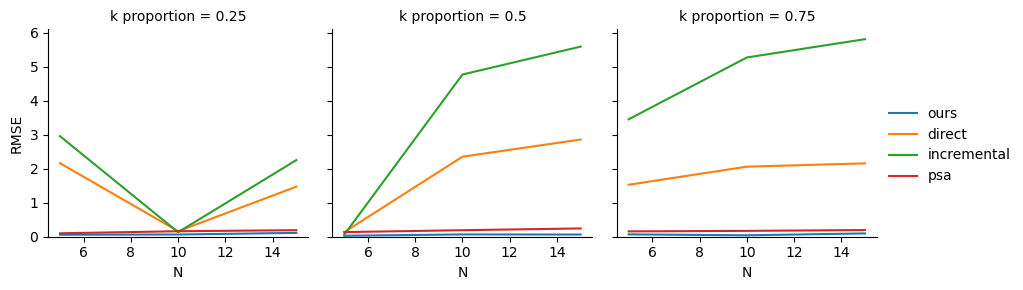

In [18]:
results_plot = results.melt(id_vars = ['items_n', 'k_prop'], value_vars = ['ours', 'direct', 'incremental', 'psa'])
results_plot = results_plot.rename(columns={'value': 'RMSE', 'items_n': 'N', 'variable': 'method', 'k_prop': "k proportion"})
g = sns.FacetGrid(results_plot, col="k proportion")
g.map(sns.lineplot, "N", "RMSE", 'method').add_legend()
plt.ylim(0)
plt.savefig('items_n_comparison.png')